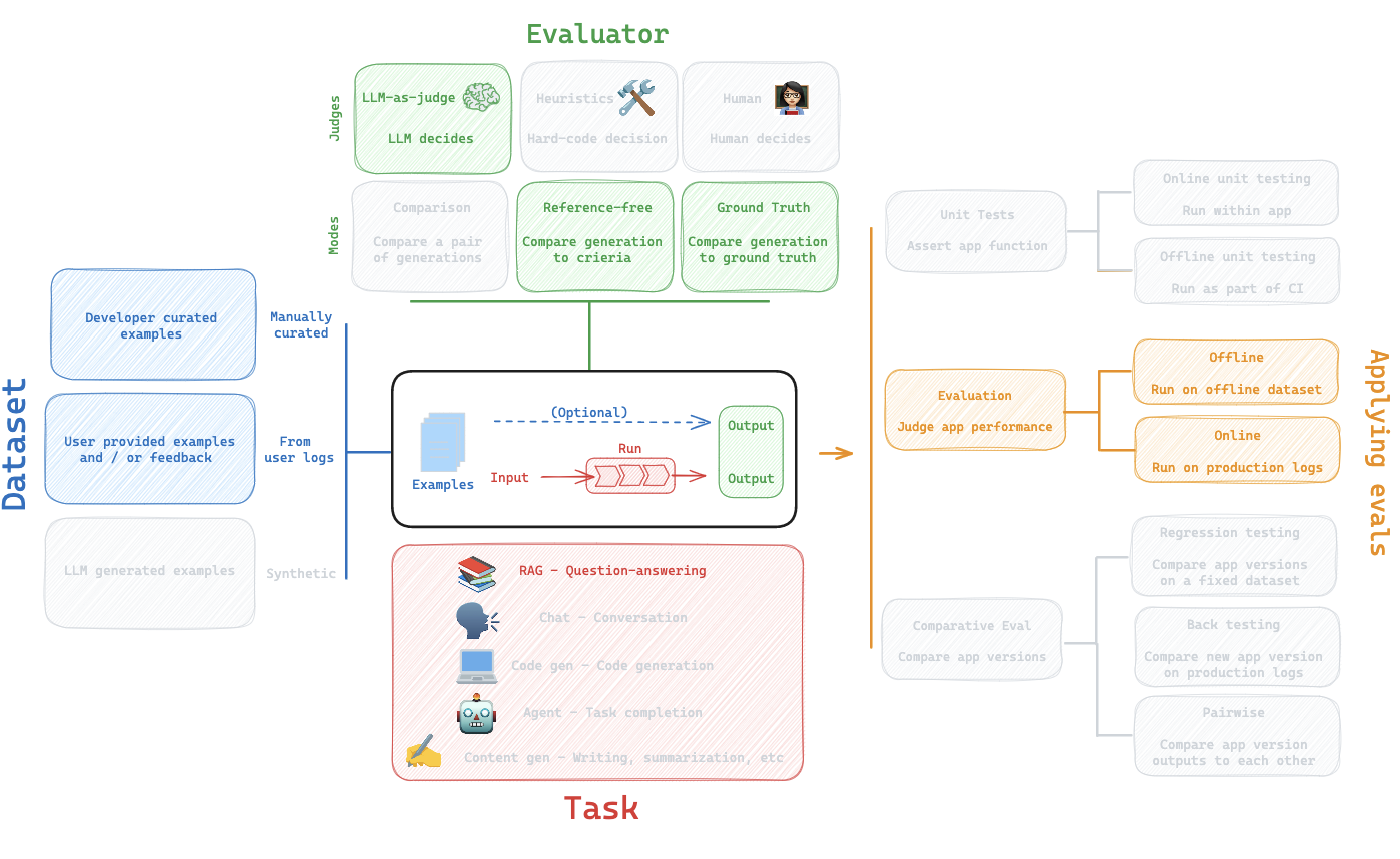

# Simple RAG (Retrieval-Augmented Generation) System

## Overview

This code implements a basic Retrieval-Augmented Generation (RAG) system for processing and querying PDF documents. The system encodes the document content into a vector store, which can then be queried to retrieve relevant information.

## Key Components

1. PDF processing and text extraction
2. Text chunking for manageable processing
3. Vector store creation using [FAISS](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) and OpenAI embeddings
4. Retriever setup for querying the processed documents
5. Evaluation of the RAG system

## Method Details

### Document Preprocessing

1. The PDF is loaded using PyPDFLoader.
2. The text is split into chunks using RecursiveCharacterTextSplitter with specified chunk size and overlap.

### Text Cleaning

A custom function `replace_t_with_space` is applied to clean the text chunks. This likely addresses specific formatting issues in the PDF.

### Vector Store Creation

1. OpenAI embeddings are used to create vector representations of the text chunks.
2. A FAISS vector store is created from these embeddings for efficient similarity search.

### Retriever Setup

1. A retriever is configured to fetch the top 2 most relevant chunks for a given query.

### Encoding Function

The `encode_pdf` function encapsulates the entire process of loading, chunking, cleaning, and encoding the PDF into a vector store.

## Key Features

1. Modular Design: The encoding process is encapsulated in a single function for easy reuse.
2. Configurable Chunking: Allows adjustment of chunk size and overlap.
3. Efficient Retrieval: Uses FAISS for fast similarity search.
4. Evaluation: Includes a function to evaluate the RAG system's performance.

## Usage Example

The code includes a test query: "What is the main cause of climate change?". This demonstrates how to use the retriever to fetch relevant context from the processed document.

## Evaluation

The system includes an `evaluate_rag` function to assess the performance of the retriever, though the specific metrics used are not detailed in the provided code.

## Benefits of this Approach

1. Scalability: Can handle large documents by processing them in chunks.
2. Flexibility: Easy to adjust parameters like chunk size and number of retrieved results.
3. Efficiency: Utilizes FAISS for fast similarity search in high-dimensional spaces.
4. Integration with Advanced NLP: Uses OpenAI embeddings for state-of-the-art text representation.

## Conclusion

This simple RAG system provides a solid foundation for building more complex information retrieval and question-answering systems. By encoding document content into a searchable vector store, it enables efficient retrieval of relevant information in response to queries. This approach is particularly useful for applications requiring quick access to specific information within large documents or document collections.

### Import libraries and environment variables

In [2]:
from __future__ import annotations

import dotenv


# Reload the variables in your '.env' file (override the existing variables)
dotenv.load_dotenv("../.env", override=True)

True

In [ ]:
import logging
import os
import sys

from dotenv import load_dotenv


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # Add the parent directory to the path since we work with notebooks
from langsmith import traceable
from langsmith.wrappers import wrap_openai
from loguru import logger
from loguru import logger as LOGGER
from loguru._defaults import LOGURU_FORMAT
from openai import OpenAI

from evaluation.evalute_rag import *
from helper_functions import *
from logging_utils import get_logger, global_log_config


global_log_config(
    log_level=logging.getLevelName("DEBUG"),
    json=False,
)
LOGGER.disable("ipykernel.")
LOGGER.disable("ipykernel.kernelbase")
LOGGER.disable("openai._base_client")

import warnings
# from pydantic.errors import PydanticDeprecatedSince20

# Filter and suppress the specific warning
# warnings.filterwarnings("ignore", category=PydanticDeprecatedSince20, message="The `__fields__` attribute is deprecated*")


Logger set up with log level: 10


### Read Docs

In [5]:
path = "../data/Understanding_Climate_Change.pdf"

### Encode document

In [6]:
def encode_pdf(path, chunk_size=1000, chunk_overlap=200):
    """
    Encodes a PDF book into a vector store using OpenAI embeddings.

    Args:
        path: The path to the PDF file.
        chunk_size: The desired size of each text chunk.
        chunk_overlap: The amount of overlap between consecutive chunks.

    Returns:
        A FAISS vector store containing the encoded book content.
    """

    # Load PDF documents
    loader = PyPDFLoader(path)
    documents = loader.load()

    # Split documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len
    )
    texts = text_splitter.split_documents(documents)
    cleaned_texts = replace_t_with_space(texts)

    # Create embeddings and vector store
    embeddings = OpenAIEmbeddings()
    vectorstore = FAISS.from_documents(cleaned_texts, embeddings)

    return vectorstore

In [ ]:
chunks_vector_store = encode_pdf(path, chunk_size=1000, chunk_overlap=200)

### Create retriever

In [8]:
chunks_query_retriever = chunks_vector_store.as_retriever(search_kwargs={"k": 2})

### Test retriever

In [9]:
test_query = "What is the main cause of climate change?"
context = retrieve_context_per_question(test_query, chunks_query_retriever)
show_context(context)

/Users/malcolm/.pyenv/versions/3.10.14/envs/rag_techniques3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Context 1:
driven by human activities, particularly the emission of greenhou se gases.  
Chapter 2: Causes of Climate Change  
Greenhouse Gases  
The primary cause of recent climate change is the increase in greenhouse gases in the 
atmosphere. Greenhouse gases, such as carbon dioxide (CO2), methane (CH4), and nitrous 
oxide (N2O), trap heat from the sun, creating a "greenhouse effect." This effect is  essential 
for life on Earth, as it keeps the planet warm enough to support life. However, human 
activities have intensified this natural process, leading to a warmer climate.  
Fossil Fuels  
Burning fossil fuels for energy releases large amounts of CO2. This includes coal, oil, and 
natural gas used for electricity, heating, and transportation. The industrial revolution marked 
the beginning of a significant increase in fossil fuel consumption, which continues to rise 
today.  
Coal


Context 2:
Most of these climate changes are attributed to very small variations in Earth's orbit tha

### Evaluate results

In [8]:
# evaluate_rag(chunks_query_retriever)

In [19]:
import bs4

from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [ ]:
# testing some stuff out
import rich

from langchain import hub


rag_prompt = hub.pull("rlm/rag-prompt")

# rich.inspect(rag_prompt, all=True)

# create sample rag bot that can be used for evaluation rag testing later on

In [28]:
### RAG bot
# SOURCE: https://docs.smith.langchain.com/tutorials/Developers/rag

# alias retriever
retriever = chunks_query_retriever

import logging

from typing import Any, List

import openai
import pysnooper
import rich

from langchain.chains import LLMChain, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import HumanMessagePromptTemplate, SystemMessagePromptTemplate
from langchain.pydantic_v1 import BaseModel
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import ConfigurableField, Runnable, RunnableBranch, RunnableLambda, RunnableMap
from langchain_openai import ChatOpenAI, OpenAI
from langsmith import traceable
from langsmith.wrappers import wrap_openai
from openai.types.chat.chat_completion import ChatCompletion


def format_docs(docs: List[Document]):
    return "\n\n".join(doc.page_content for doc in docs)

class RagBot:

    def __init__(self, retriever = retriever, model: str = "gpt-4o", llm: Any = None):
        self._retriever = retriever
        # Wrapping the client instruments the LLM
        self._client = wrap_openai(openai.Client())
        self._model = model
        if llm is None:
            self._llm = ChatOpenAI(
                name="ChatOpenAI",
                streaming=True,
                model=self._model,
                max_retries=9,
                # max_tokens=900,
                temperature=0.0,
            )
        else:
            self._llm = llm

    @traceable()
    def execute_chain(self, question: str):
        chain = self.build_chain(question)
        return chain.invoke(question)

    @traceable()
    def retrieve_docs(self, question):
        return self._retriever.invoke(question)

    # @traceable()
    # def build_chain(self, question):


    @traceable()
    def invoke_llm(self, question, docs):
        response: ChatCompletion = self._client.chat.completions.create(
            model=self._model,
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful AI code assistant with expertise in climate change."
                    " Use the following docs to produce a concise code solution to the user question.\n\n"
                    f"## Docs\n\n{docs}",
                },
                {"role": "user", "content": question},
            ],
        )

        # Evaluators will expect "answer" and "contexts"
        return {
            "answer": response.choices[0].message.content,
            "contexts": [str(doc) for doc in docs],
        }

    # @pysnooper.snoop()
    @traceable()
    def build_chain(self, question):
        # NOTE: https://python.langchain.com/v0.2/docs/tutorials/rag/
        # NOTE: Look at this for inspiration
        """
        Builds a RAG chain using LangChain's ChatPromptTemplate.from_messages.

        Args:
            question: The user's question.

        Returns:
            A LangChain LLMChain object representing the RAG chain.
        """
        system_template = (
            "You are a helpful AI code assistant with expertise in climate change. "
            "Use the following docs to produce a concise code solution to the user question.\n\n"
            "## Docs\n\n{context}"
        )

        # SystemMessage
        # This represents a message with role "system", which tells the model how to behave. Not every model provider supports this.
        system_message_prompt = SystemMessagePromptTemplate.from_template(system_template)

        # human_template = "{question}"
        # human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)

        # chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])

        # # chain = LLMChain(llm=self._llm, prompt=chat_prompt)

        # question_answer_chain = create_stuff_documents_chain(self._llm, chat_prompt)
        # # rag_chain = create_retrieval_chain(self._retriever, question_answer_chain)

        base_human_template = "You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\n\nQuestion: {question} \n\nContext: {context} \n\nAnswer:"

        base_prompt = ChatPromptTemplate.from_messages([
        ("system", system_template),
        ("human", base_human_template),
        ])

        LOGGER.debug(base_prompt)


        rag_chain = (
            {"context": retriever | format_docs, "question": RunnablePassthrough()}
            | base_prompt
            | self._llm
            | StrOutputParser()
        )

        return rag_chain

    @traceable()
    def get_answer(self, question: str):
        docs = self.retrieve_docs(question)
        return self.invoke_llm(question, docs)

rag_bot = RagBot(retriever)

In [29]:
# bot smoke test

response = rag_bot.execute_chain(test_query)
# rich.print(response["answer"][:150])
rich.print(response)

# rich.inspect(rag_bot._llm, all=True)

# rag_bot._llm.get_input_schema()


The main cause of recent climate change is the increase in greenhouse gases in the atmosphere, driven by human 
activities such as burning fossil fuels.

# Let's explore the chain a little bit


In [30]:
bot_chain = rag_bot.build_chain(test_query)
rich.inspect(bot_chain, all=True)

╭─────────────────────────────────────────── <class '__main__.RagBot'> ───────────────────────────────────────────╮
│ ╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ <__main__.RagBot object at 0x30dedfe80>                                                                     │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                                                 │
│           _client = <openai.OpenAI object at 0x30dedca90>                                                       │
│          __dict__ = {                                                                                           │
│                         '_retriever': VectorStoreRetriever(                                                     │
│                             tags=['FAISS', 'OpenAIEmbeddings'],                                                 │
│                             vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x30d538a90>,   │
│                             search_kwargs={'k': 2}                                                              │
│                         ),                                                                                      │
│                         '_client': <openai.OpenAI object at 0x30dedca90>,                                       │
│                         '_model': 'gpt-4o',                                                                     │
│                         '_llm': ChatOpenAI(                                                                     │
│                             name='ChatOpenAI',                                                                  │
│                             client=<openai.resources.chat.completions.Completions object at 0x3122a1fc0>,       │
│                             async_client=<openai.resources.chat.completions.AsyncCompletions object at          │
│                     0x31247c670>,                                                                               │
│                             model_name='gpt-4o',                                                                │
│                             temperature=0.0,                                                                    │
│                             openai_api_key=SecretStr('**********'),                                             │
│                             openai_proxy='',                                                                    │
│                             max_retries=9,                                                                      │
│                             streaming=True                                                                      │
│                         )                                                                                       │
│                     }                                                                                           │
│           __doc__ = None                                                                                        │
│            _model = 'gpt-4o'                                                                                    │
│        __module__ = '__main__'                                                                                  │
│        _retriever = VectorStoreRetriever(                                                                       │
│                         tags=['FAISS', 'OpenAIEmbeddings'],                                                     │
│                         vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x30d538a90>,       │
│                         search_kwargs={'k': 2}                                                                  │
│                     )                                 

# Define a function that will:

1. Take a dataset example
2. Extract the relevant key (e.g., question) from the example
3. Pass it to the RAG chain
4. Return the relevant output values from the RAG chain

In [12]:
def predict_rag_answer(example: dict):
    """Use this for answer evaluation"""
    response = rag_bot.get_answer(example["question"])
    return {"answer": response["answer"]}

def predict_rag_answer_with_context(example: dict):
    """Use this for evaluation of retrieved documents and hallucinations"""
    response = rag_bot.get_answer(example["question"])
    return {"answer": response["answer"], "contexts": response["contexts"]}

## Evaluator[](https://docs.smith.langchain.com/tutorials/Developers/rag#evaluator)

There are at least 4 types of RAG eval that users are typically interested in.

1. **Response vs reference answer**

- `Goal`: Measure "*how similar/correct is the RAG chain answer, relative to a ground-truth answer*"
- `Mode`: Uses ground truth (reference) answer supplied through a dataset
- `Judge`: Use LLM-as-judge to assess answer correctness.

1. **Response vs input**

- `Goal`: Measure "*how well does the generated response address the initial user input*"
- `Mode`: Reference-free, because it will compare the answer to the input question
- `Judge`: Use LLM-as-judge to assess answer relevance, helpfulness, etc.

1. **Response vs retrieved docs**

- `Goal`: Measure "*to what extent does the generated response agree with the retrieved context*"
- `Mode`: Reference-free, because it will compare the answer to the retrieved context
- `Judge`: Use LLM-as-judge to assess faithfulness, hallucinations, etc.

1. **Retrieved docs vs input**

- `Goal`: Measure "*how good are my retrieved results for this query*"
- `Mode`: Reference-free, because it will compare the question to the retrieved context
- `Judge`: Use LLM-as-judge to assess relevance

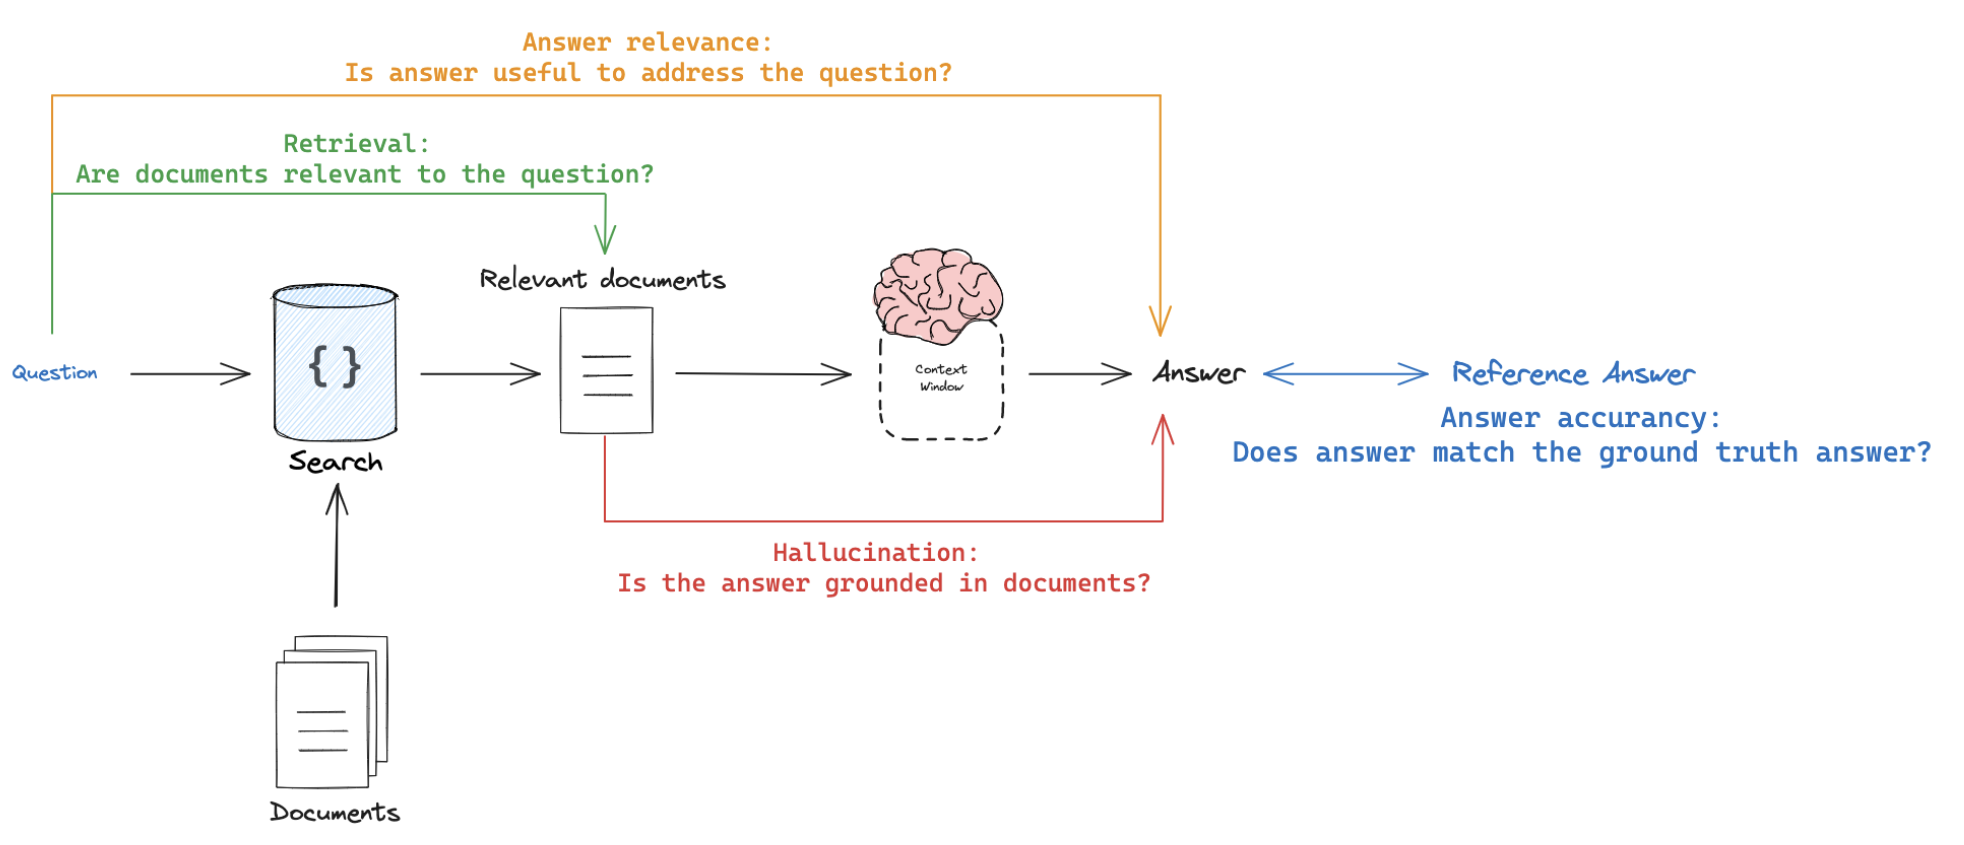

### **Response vs reference answer**[](https://docs.smith.langchain.com/tutorials/Developers/rag#response-vs-reference-answer)

Here is an example prompt that we can use:

https://smith.langchain.com/hub/langchain-ai/rag-answer-vs-reference

Here is the a video from our LangSmith evaluation series for reference:

https://youtu.be/lTfhw_9cJqc?feature=shared

Here is our evaluator function:

- `run` is the invocation of `predict_rag_answer`, which has key `answer`
- `example` is from our eval set, which has keys `question` and `output_answer`
- We extract these values and pass them into our grader

In [13]:
import langsmith

from langsmith.evaluation import evaluate


langsmith_client = langsmith.Client()
dataset_name = "Climate Change Q&A"

In [ ]:
# langsmith_client.list_datasets()

In [14]:
from langchain import hub
from langchain.agents import AgentExecutor
from langchain_anthropic import ChatAnthropic
from langchain_core.documents import Document
from langchain_core.messages import AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langsmith.evaluation import EvaluationResults, LangChainStringEvaluator, evaluate
from langsmith.run_trees import RunTree
from langsmith.schemas import Example, Run


# Grade prompt
grade_prompt_answer_accuracy = prompt = hub.pull("langchain-ai/rag-answer-vs-reference")

def answer_evaluator(run: Run, example: Example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get question, ground truth answer, RAG chain answer
    question = example.inputs["question"]
    reference = example.outputs["output_answer"]
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke({"question": question,
                                  "correct_answer": reference,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_v_reference_score", "score": score}

/Users/malcolm/.pyenv/versions/3.10.14/envs/rag_techniques3/lib/python3.10/site-packages/langchain/hub.py:86: DeprecationWarning: The `langchainhub sdk` is deprecated.
Please use the `langsmith sdk` instead:
  pip install langsmith
Use the `pull_prompt` method.
  res_dict = client.pull_repo(owner_repo_commit)


Now, we kick off evaluation:

- `predict_rag_answer`: Takes an `example` from our eval set, extracts the question, passes to our RAG chain
- `answer_evaluator`: Passes RAG chain answer, question, and ground truth answer to an evaluator

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    experiment_results = evaluate(
        predict_rag_answer,
        data=dataset_name,
        evaluators=[answer_evaluator],
        experiment_prefix="rag-answer-v-reference",
        metadata={"version": "Climate Change Q&A, gpt-4o"},
    )

    experiment_results

View the evaluation results for experiment: 'rag-answer-v-reference-ee1e6400' at:
https://smith.langchain.com/o/631f824f-4072-5bc6-b1f6-924eb5dfd83f/datasets/2f8d7951-767b-4548-9b06-8d11f43c9884/compare?selectedSessions=56ae0614-56f6-4c79-94de-750007ed0811




0it [00:00, ?it/s]

/Users/malcolm/.pyenv/versions/3.10.14/envs/rag_techniques3/lib/python3.10/site-packages/pydantic/main.py:1059: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  warnings.warn(
/Users/malcolm/.pyenv/versions/3.10.14/envs/rag_techniques3/lib/python3.10/site-packages/pydantic/main.py:1059: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  warnings.warn(
/Users/malcolm/.pyenv/versions/3.10.14/envs/rag_techniques3/lib/python3.10/site-packages/pydantic/main.py:1059: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guid

# Response vs input
Here is an example prompt that we can use:

https://smith.langchain.com/hub/langchain-ai/rag-answer-helpfulness

The information flow is similar to above, but we simply look at the run answer versus the example question.

In [ ]:
# Grade prompt
grade_prompt_answer_helpfulness = prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def answer_helpfulness_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer helpfulness
    """

    # Get question, ground truth answer, RAG chain answer
    question = example.inputs["question"]
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_answer_helpfulness | llm

    # Run evaluator
    score = answer_grader.invoke({"question": question,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_helpfulness_score", "score": score}

In [ ]:
experiment_results = evaluate(
    predict_rag_answer,
    data=dataset_name,
    evaluators=[answer_helpfulness_evaluator],
    experiment_prefix="rag-answer-helpfulness",
    max_concurrency=4,
    metadata={"version": "Climate Change Q&A, gpt-4o"},
)

### **Response vs retrieved docs**[](https://docs.smith.langchain.com/tutorials/Developers/rag#response-vs-retrieved-docs)

Here is an example prompt that we can use:

https://smith.langchain.com/hub/langchain-ai/rag-answer-hallucination

Here is the a video from our LangSmith evaluation series for reference:

https://youtu.be/IlNglM9bKLw?feature=shared

In [ ]:
# Prompt
grade_prompt_hallucinations = prompt = hub.pull("langchain-ai/rag-answer-hallucination")

def answer_hallucination_evaluator(run, example) -> dict:
    """
    A simple evaluator for generation hallucination
    """

    # RAG inputs
    question = example.inputs["question"]
    contexts = run.outputs["contexts"]

    # RAG answer
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_hallucinations | llm

    # Get score
    score = answer_grader.invoke({"documents": contexts,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_hallucination", "score": score}

In [ ]:
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[answer_hallucination_evaluator],
    experiment_prefix="rag-answer-hallucination",
    max_concurrency=4,
    metadata={"version": "Climate Change Q&A, gpt-4o"},
)

### **Retrieved docs vs input**[](https://docs.smith.langchain.com/tutorials/Developers/rag#retrieved-docs-vs-input)

Here is an example prompt that we can use:

https://smith.langchain.com/hub/langchain-ai/rag-document-relevance

Here is the a video from our LangSmith evaluation series for reference:

https://youtu.be/Fr_7HtHjcf0?feature=shared

In [ ]:
# Grade prompt
grade_prompt_doc_relevance = hub.pull("langchain-ai/rag-document-relevance")

def docs_relevance_evaluator(run, example) -> dict:
    """
    A simple evaluator for document relevance
    """

    # RAG inputs
    question = example.inputs["question"]
    contexts = run.outputs["contexts"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_doc_relevance | llm

    # Get score
    score = answer_grader.invoke({"question":question,
                                  "documents":contexts})
    score = score["Score"]

    return {"key": "document_relevance", "score": score}

In [ ]:
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[docs_relevance_evaluator],
    experiment_prefix="rag-doc-relevance",
    max_concurrency=4,
    metadata={"version": "Climate Change Q&A, gpt-4o"},
)

## Evaluating intermediate steps[](https://docs.smith.langchain.com/tutorials/Developers/rag#evaluating-intermediate-steps)

Above, we returned the retrieved documents as part of the final answer.

However, we will show that this is not required.

We can isolate them as intermediate chain steps.

See detail on isolating intermediate chain steps [here](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_on_intermediate_steps).

Here is the a video from our LangSmith evaluation series for reference:

https://youtu.be/yx3JMAaNggQ?feature=shared

In [ ]:
from langsmith.evaluation import evaluate
from langsmith.schemas import Example, Run


def document_relevance_grader(root_run: Run, example: Example) -> dict:
    """
    A simple evaluator that checks to see if retrieved documents are relevant to the question
    """

    # Get specific steps in our RAG pipeline, which are noted with @traceable decorator
    rag_pipeline_run = next(
        run for run in root_run.child_runs if run.name == "get_answer"
    )
    retrieve_run = next(
        run for run in rag_pipeline_run.child_runs if run.name == "retrieve_docs"
    )
    contexts = "\n\n".join(doc.page_content for doc in retrieve_run.outputs["output"])
    question = example.inputs["question"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_doc_relevance | llm

    # Get score
    score = answer_grader.invoke({"question":question,
                                  "documents":contexts})
    score = score["Score"]

    return {"key": "document_relevance", "score": score}

def answer_hallucination_grader(root_run: Run, example: Example) -> dict:
    """
    A simple evaluator that checks to see the answer is grounded in the documents
    """

    # RAG input
    rag_pipeline_run = next(
        run for run in root_run.child_runs if run.name == "get_answer"
    )
    retrieve_run = next(
        run for run in rag_pipeline_run.child_runs if run.name == "retrieve_docs"
    )
    contexts = "\n\n".join(doc.page_content for doc in retrieve_run.outputs["output"])

    # RAG output
    prediction = rag_pipeline_run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_hallucinations | llm

    # Get score
    score = answer_grader.invoke({"documents": contexts,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_hallucination", "score": score}

experiment_results = evaluate(
    predict_rag_answer,
    data=dataset_name,
    evaluators=[document_relevance_grader, answer_hallucination_grader],
    max_concurrency=4,
    metadata={"version": "Climate Change Q&A, gpt-4o"},
)

-------------------------

# Evalute w/ Langsmith

## Define metrics

After creating our dataset, we can now define some metrics to evaluate our responses on. Since we have an expected answer, we can compare to that as part of our evaluation. However, we do not expect our application to output those exact answers, but rather something that is similar. This makes our evaluation a little trickier.

In addition to evaluating correctness, let's also make sure our answers are short and concise. This will be a little easier - we can define a simple Python function to measure the length of the response.

Let's go ahead and define these two metrics.

For the first, we will use an LLM to judge whether the output is correct (with respect to the expected output). This LLM-as-a-judge is relatively common for cases that are too complex to measure with a simple function. We can define our own prompt and LLM to use for evaluation here:

In [ ]:
# # SOURCE: https://docs.smith.langchain.com/tutorials/Developers/evaluation

# from langchain_anthropic import ChatAnthropic
# from langchain_core.prompts.prompt import PromptTemplate
# from langsmith.evaluation import LangChainStringEvaluator

# dataset_name = "Climate Change Q&A"


# # # Storing inputs in a dataset lets us
# # # run chains and LLMs over a shared set of examples.
# # dataset = client.create_dataset(
# #     dataset_name=dataset_name,
# #     description="Questions and answers about climate change.",
# # )
# # for input_prompt, output_answer in example_inputs:
# #     client.create_example(
# #         inputs={"question": input_prompt},
# #         outputs={"answer": output_answer},
# #         metadata={"source": "Various"},
# #         dataset_id=dataset.id,
# #     )

# _PROMPT_TEMPLATE = """You are an expert professor specialized in grading students' answers to questions.
# You are grading the following question:
# {query}
# Here is the real answer:
# {answer}
# You are grading the following predicted answer:
# {result}
# Respond with CORRECT or INCORRECT:
# Grade:
# """

# PROMPT = PromptTemplate(
#     input_variables=["query", "answer", "result"], template=_PROMPT_TEMPLATE
# )
# eval_llm = ChatAnthropic(temperature=0.0)

# qa_evaluator = LangChainStringEvaluator("qa", config={"llm": eval_llm, "prompt": PROMPT})

For evaluating the length of the response, this is a lot easier! We can just define a simple function that checks whether the actual output is less than 2x the length of the expected result.

In [ ]:
# from langsmith.schemas import Run, Example

# def evaluate_length(run: Run, example: Example) -> dict:
#     prediction = run.outputs.get("output") or ""
#     required = example.outputs.get("answer") or ""
#     score = int(len(prediction) < 2 * len(required))
#     return {"key":"length", "score": score}

# Run Evaluations

Great! So now how do we run evaluations? Now that we have a dataset and evaluators, all that we need is our application! We will build a simple application that just has a system message with instructions on how to respond and then passes it to the LLM. We will build this using the OpenAI SDK directly:

In [ ]:
# # my app

# import openai

# openai_client = openai.Client()

# def my_app(question: str):
#     return openai_client.chat.completions.create(
#         model="gpt-3.5-turbo",
#         temperature=0,
#         messages=[
#             {
#                 "role": "system",
#                 "content": "Respond to the users question in a short, concise manner (one short sentence)."
#             },
#             {
#                 "role": "user",
#                 "content": question,
#             }
#         ],
#     ).choices[0].message.content

Before running this through LangSmith evaluations, we need to define a simple wrapper that maps the input keys from our dataset to the function we want to call, and then also maps the output of the function to the output key we expect.



In [ ]:
# def langsmith_app(inputs):
#     output = my_app(inputs["question"])
#     return {"output": output}

Great! Now we're ready to run evaluation. Let's do it!

In [ ]:
# from langsmith.evaluation import evaluate

# experiment_results = evaluate(
#     langsmith_app, # Your AI system
#     data=dataset_name, # The data to predict and grade over
#     evaluators=[evaluate_length, qa_evaluator], # The evaluators to score the results
#     experiment_prefix="openai-3.5", # A prefix for your experiment names to easily identify them
# )
